<a href="https://colab.research.google.com/github/tompc35/data-labs/blob/master/OOI_ADCP_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OOI Endurance Array - ADCP time series analysis

This notebook expands on time series analysis techniques using an Acoustic Doppler Current Profiler (ADCP) current meter data set. The analysis techniques include:

* Masking contaminated data near the surface
* Depth averaging profiles
* Correlation functions
* Spectral analysis

Basic knowledge of the concepts behind correlation functions, effective degrees of freedom and spectral analysis is assumed.

![Endurance Array](https://ooinet.oceanobservatories.org/img/home/coastal_endurance/endurance_1.jpg)

This example focuses on ADCP data from the inshore mooring on the Oregon line. The ADCP is mounted at the bottom and looks upward throughout the water column, measuring velocity at a series of depths.

![Oregon Endurance Line](https://ooinet.oceanobservatories.org/img/home/coastal_endurance/endurance_2.png)


The photo below shows an ADCP deployed at the OOI Axial Seamount site. The four red cylinders are the upward-facing transducers, which send and receive acoustic signals. Image source: https://oceanobservatories.org/instrument-class/adcp/

![ADCP photo](https://oceanobservatories.org/wp-content/uploads/2016/10/adcp.r1735_sdi1_2014-08-040_45_40_14317_spacialrelationshipoflv01atolj01a_med.jpg)

The [OOI Data Explorer](https://dataexplorer.oceanobservatories.org) can be used to access data from any OOI instrument. The data typically come in NetCDF format.

The data from the bottom-mounted ADCP at the Oregon inshore mooring can be found [here](https://dataexplorer.oceanobservatories.org/#metadata/103699/station/84/sensor/data?start=2014-04-18T00:21:00Z&end=2025-05-06T20:31:00Z&leg_clim_max=false&leg_clim_min=false&leg_minmax=false&fr=subsite.node).

### Import libraries and load data

In addition to standard libraries, specialized physical oceanography functions (used for depth averaging and filtering) are installed from https://github.com/physoce/physoce-py

In [1]:
!pip install netcdf4==1.5.0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib import mlab
import scipy.signal as signal

In [3]:
thredds_dataset = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth/deployment0009_CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth_20180403T043000-20180912T224545.920000.nc'

The ADCP data for April-September 2018 is included in this repository. The data set is in NetCDF format, and can be easily opened with the [xarray](http://xarray.pydata.org) package.

In [4]:
# insert code here
ds = xr.open_dataset(thredds_dataset)

In [5]:
# insert code here
ds

<xarray.Dataset> Size: 34MB
Dimensions:                                    (obs: 7811, bin: 30)
Coordinates:
  * obs                                        (obs) int32 31kB 0 1 ... 7810
    depth                                      (obs) float64 62kB ...
  * bin                                        (bin) int32 120B 0 1 2 ... 28 29
    time                                       (obs) datetime64[ns] 62kB ...
Data variables: (12/50)
    num_cells                                  (obs) float32 31kB ...
    ensemble_number                            (obs) float32 31kB ...
    transducer_depth                           (obs) float32 31kB ...
    pitch                                      (obs) float32 31kB ...
    cell_length                                (obs) float32 31kB ...
    driver_timestamp                           (obs) datetime64[ns] 62kB ...
    ...                                         ...
    correlation_magnitude_beam2                (obs, bin) float32 937kB ...
    correlation_magnitude_beam3                (obs, bin) float32 937kB ...
    correlation_magnitude_beam1                (obs, bin) float32 937kB ...
    echo_intensity_beam4                       (obs, bin) float32 937kB ...
    echo_intensity_beam3                       (obs, bin) float32 937kB ...
    echo_intensity_beam1                       (obs, bin) float32 937kB ...
Attributes: (12/73)
    node:                               MFD35
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_inst
    stream:                             adcp_velocity_earth
    ...                                 ...
    geospatial_vertical_positive:       down
    lat:                                44.65685
    lon:                                -124.09553
    DODS.strlen:                        18
    DODS.dimName:                       string18
    DODS_EXTRA.Unlimited_Dimension:     obs

In [6]:
ds['time']

<xarray.DataArray 'time' (obs: 7811)> Size: 62kB
[7811 values with dtype=datetime64[ns]]
Coordinates:
  * obs      (obs) int32 31kB 0 1 2 3 4 5 6 ... 7805 7806 7807 7808 7809 7810
    depth    (obs) float64 62kB ...
    time     (obs) datetime64[ns] 62kB ...
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T
    _ChunkSizes:    7811

### ADCP post-processing

First, for convenience, create variables for eastward velocity ($u$) and northward velocity ($v$) in units of m/s.

In [7]:
ds['u'] = ds['water_velocity_east']/1000
ds['u'].attrs['units'] = 'm/s'

ds['v'] = ds['water_velocity_north']/1000
ds['v'].attrs['units'] = 'm/s'


The dataset provided by OOI includes the following variables:
* `depth_from_pressure` is the total water column depth, calculated from the pressure sensor. Dimensions: `(obs)`
* `bin_depths` is the depth of each ADCP bin below the sea surface, which moves up and down. The bin depths constantly change in time. Dimensions: `(obs, bin)`

The code below creates additional variables for keeping track of depths in the ADCP data:
* `bin_height` is the height of each ADCP bin above the bottom. These heights are fixed, since the ADCP is mounted at the bottom. Dimensions: `(bin)`
* `bin_depths_avg` is the average depth below the surface for each ADCP bin. These depths are fixed in time since they are defined in relation to a time average. Dimensions: `(bin)`
* `sea_surface` is the height of the sea surface, relative to the time average. Dimensions: `(obs)`
* `bottom_depth_avg` is the average bottom depth, calculated from the pressure sensor. This is a single value with no dimensions. Dimensions: `()`

In [8]:
ds['bin_height'] =  ds['depth_from_pressure'][0] - ds['bin_depths'][0,:]
ds['bin_height'].attrs['units'] = 'm'

ds['sea_surface'] = ds['depth_from_pressure']-np.mean(ds['depth_from_pressure'])
ds['sea_surface'].attrs['units'] = 'm'

### ADCP quality control

The acoustic signal of the ADCP can be reflected at the sea surface, leading to contamination. This plot shows the echo intensity for one of the four beams of the ADCP. There is bad data near the sea surface, as well as data above the sea surface which needs to be discarded.

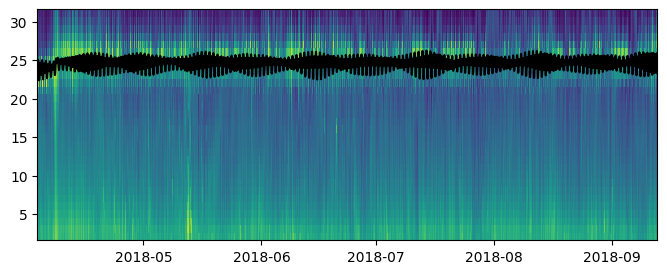

In [9]:
plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],
           ds['corrected_echo_intensity_beam1'].T)
plt.plot(ds['time'],ds['depth_from_pressure'],'k-')

To get a better look, select a date range for plotting a subset of the data.

In [10]:
t1 = np.datetime64('2018-07-01 00:00:00')
t2 = np.datetime64('2018-07-15 00:00:00')

(np.float64(17713.0), np.float64(17727.0))

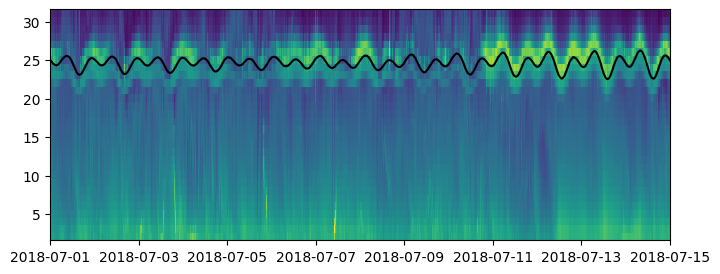

In [11]:
plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],
           ds['corrected_echo_intensity_beam1'].T)
plt.plot(ds['time'],ds['depth_from_pressure'],'k-')
plt.xlim([t1,t2])

Looking at the velocity, the noise near the surface is apparent.

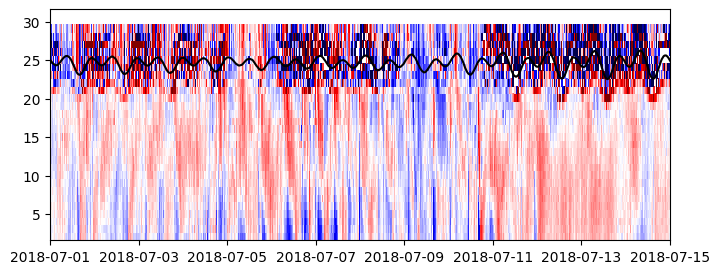

In [12]:
plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['u'].T,cmap='seismic')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.xlim([t1,t2])
plt.clim([-0.4,0.4])

We can remove the noise by selecting only good data at least 4m below the sea surface.

In [13]:
good = (ds['bin_depths'] > 4)

In [14]:
ds['u'].where(good)

<xarray.DataArray 'u' (obs: 7811, bin: 30)> Size: 937kB
array([[ 0.04 ,  0.055,  0.055, ...,    nan,    nan,    nan],
       [ 0.035,  0.039,  0.032, ...,    nan,    nan,    nan],
       [ 0.054,  0.046,  0.041, ...,    nan,    nan,    nan],
       ...,
       [-0.015, -0.063, -0.063, ...,    nan,    nan,    nan],
       [-0.009, -0.046, -0.079, ...,    nan,    nan,    nan],
       [-0.036, -0.074, -0.071, ...,    nan,    nan,    nan]],
      dtype=float32)
Coordinates:
  * obs      (obs) int32 31kB 0 1 2 3 4 5 6 ... 7805 7806 7807 7808 7809 7810
    depth    (obs) float64 62kB 2.3 2.321 2.346 2.372 ... 2.59 2.592 2.59 2.578
  * bin      (bin) int32 120B 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29
    time     (obs) datetime64[ns] 62kB 2018-04-03T04:30:00 ... 2018-09-12T22:...
Attributes:
    units:    m/s

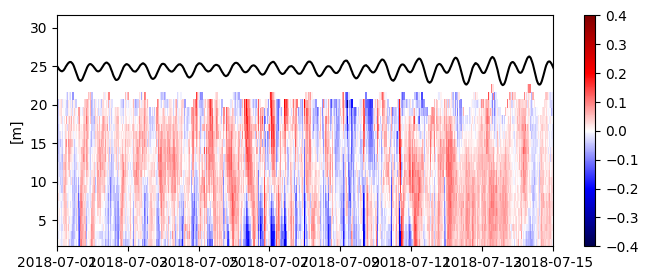

In [15]:
plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['u'].where(good).T,cmap='seismic')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-')
plt.ylabel('[m]')
plt.xlim([t1,t2])
plt.clim([-0.4,0.4])
plt.colorbar()

### Exercise

Plot the northward velocity ($v$) variable as a function of time and height above the bottom. Which velocity component tends to be stronger, the $u$ or $v$ component?

In [16]:
# insert code here

### Compute depth-averaged velocity

The averaged of the velocity over all depths of the water column is called the depth-averaged velocity. A function for computing the depth averaged velocity is included in the `tseries.py` module.

In [17]:
ds['uda'] = ds['u'].mean(dim='bin')
ds['uda'].attrs['units'] = 'm/s'
ds['vda'] = ds['v'].mean(dim='bin')
ds['vda'].attrs['units'] = 'm/s'

Text(0, 0.5, '[m/s]')

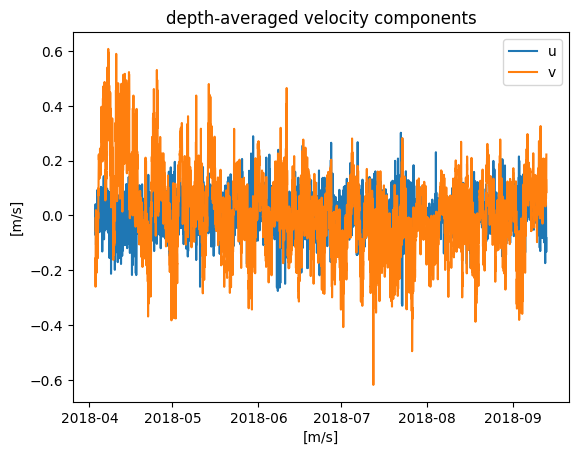

In [18]:
plt.figure()
plt.plot(ds['time'],ds['uda'])
plt.plot(ds['time'],ds['vda'])
plt.xlabel('[m/s]')
plt.legend(['u','v'])
plt.title('depth-averaged velocity components')
plt.ylabel('[m/s]')

<ipython-input-19-1c7dc357c849>:5: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([h1,h2],['individual depths','depth average']);


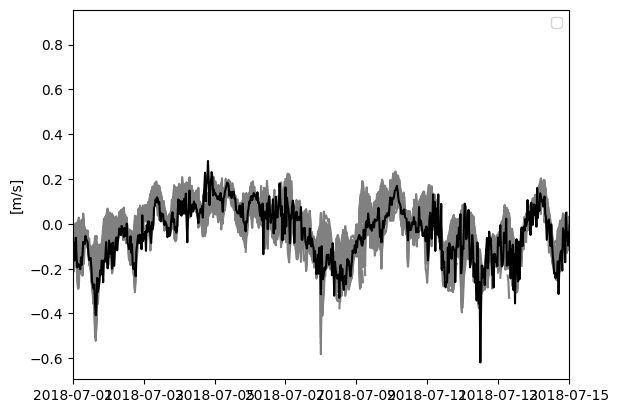

In [19]:
plt.figure()
h1 = plt.plot(ds['time'],ds['v'].where(good),color='gray');
h2 = plt.plot(ds['time'],ds['vda'],color='k');
plt.xlim([t1,t2]);
plt.legend([h1,h2],['individual depths','depth average']);
plt.ylabel('[m/s]');

### Exercise

Make a scatter plot between the depth-averaged $\bar{u}$ and $\bar{v}$ velocity components. Which component tends to have a greater magnitude, and why?

### Correlation functions

**Goal:** Based on the decorrelation time scale, how many *effective* degrees of freedom ($N^*$) does this time series have?

#### Preliminary exercises

How many samples ($N$) are in the depth-averaged $\bar{v}$ time series?

What is the time interval $\Delta t$ betwen samples?

*insert answer here*

#### Manually computing autocorrelation

Correlation at zero lag ($\tau$ = 0).

In [20]:
# insert code here
rmat = np.corrcoef(ds['vda'],ds['vda'])
rmat

array([[1., 1.],
       [1., 1.]])

In [21]:
# insert code here
r_0 = rmat[1,0]
r_0

np.float64(1.0)

Correlation at lag ($\tau$ = $\Delta t$).

In [22]:
# insert code here
r_1 = np.corrcoef(ds['vda'][1:],ds['vda'][:-1])[1,0]
print('r(tau=0.5 hrs)',np.round(r_1,4))

r(tau=0.5 hrs) 0.8942


Correlation at lag ($\tau$ = 2$\Delta t$).

In [23]:
# insert code here
r_2 = np.corrcoef(ds['vda'][2:],ds['vda'][:-2])[1,0]
print('r(tau=1 hr)',np.round(r_2,4))

r(tau=1 hr) 0.8789


(array([17624.25, 17624.5 , 17624.75, 17625.  , 17625.25, 17625.5 ,
        17625.75, 17626.  , 17626.25]),
 [Text(17624.25, 0, '04-03 06'),
  Text(17624.5, 0, '04-03 12'),
  Text(17624.75, 0, '04-03 18'),
  Text(17625.0, 0, '04-04 00'),
  Text(17625.25, 0, '04-04 06'),
  Text(17625.5, 0, '04-04 12'),
  Text(17625.75, 0, '04-04 18'),
  Text(17626.0, 0, '04-05 00'),
  Text(17626.25, 0, '04-05 06')])

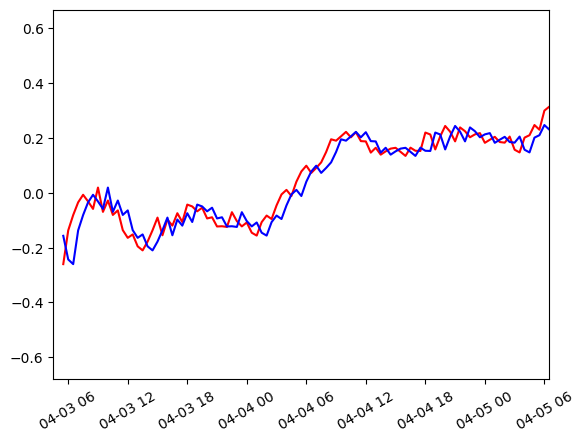

In [24]:
plt.figure()
plt.plot(ds['time'][2:],ds['vda'][2:],'r-')
plt.plot(ds['time'][2:],ds['vda'][:-2],'b-')
plt.xlim([ds['time'][0],ds['time'][100]])
plt.xticks(rotation=30)

#### Exercise

Compute the autocorrelation (r) for a lag of $\tau$ = 3 hours

In [25]:
# insert code here

### Autocorrelation function

Computing cross-correlation and autocorrelation functions is common enough that there is a matplotlib function to plot them. This function also allows you to automatically detrend the data beforehand.

Text(0.5, 1.0, 'autocorrelation function, depth-averaged v')

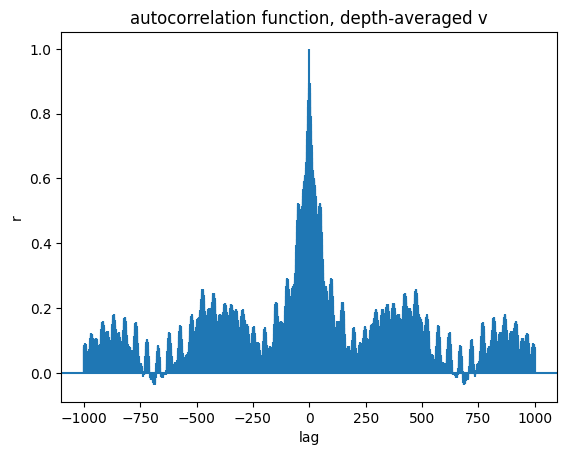

In [26]:
plt.figure()
lags,r,_,_ = plt.xcorr(ds['vda'],ds['vda'],detrend=mlab.detrend,maxlags=1000);
plt.xlabel('lag')
plt.ylabel('r')
plt.title('autocorrelation function, depth-averaged v')

#### Exercises

* From the autocorrelation plot above, estimate the decorrelation time scale (the time lag $\tau$ at which $r$ decreases to 0, in hours).
* Based on the decorrelation time scale, how many *effective* degrees of freedom ($N^*$) does this time series have?

### Spectral analysis intro

These exercises use the time series for depth-averaged velocity $\bar{v}$ and bottom pressure.

Text(0.5, 1.0, 'depth-averaged velocity $v$')

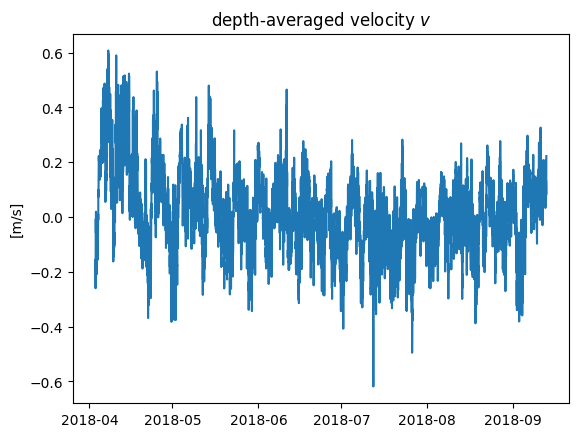

In [27]:
plt.figure()
plt.plot(ds['time'],ds['vda'])
plt.ylabel('[m/s]')
plt.title('depth-averaged velocity $v$')

Text(0.5, 1.0, 'CTD pressure')

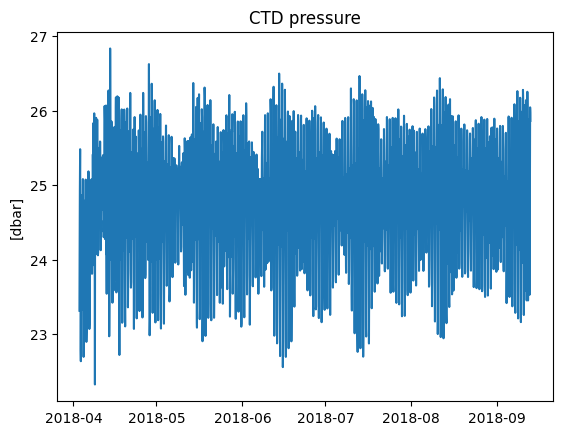

In [28]:
plt.figure()
plt.plot(ds['time'],ds['int_ctd_pressure'])
plt.ylabel('[dbar]')
plt.title('CTD pressure')

### Exercises

* How many samples $N$ are in the time series?
* What is the sample interval $\Delta t$, in hours? In days?
* What is the sampling frequency of the time series (in cycles per day)?
* What is the fundamental frequency of the time series (in cycles per day)?
* What is the Nyquist frequency of the time series (in cycles per day)?


In [29]:
from scipy.signal import periodogram

f,S = periodogram(ds['vda'],fs=48.)

Text(0.5, 1.0, ' periodogram, depth-averaged v')

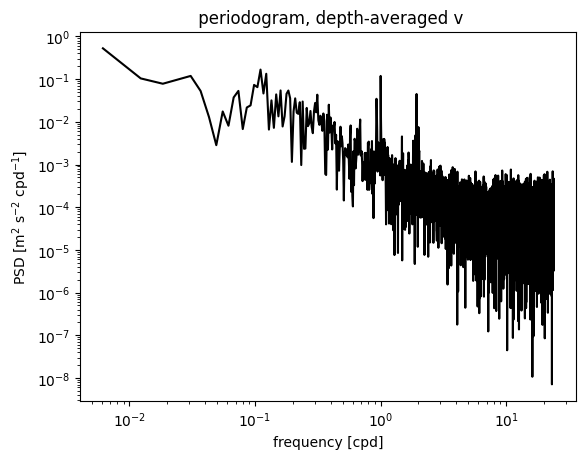

In [30]:
plt.figure()
plt.loglog(f[1:],S[1:],'k-')
plt.xlabel('frequency [cpd]')
plt.ylabel('PSD [m$^2$ s$^{-2}$ cpd$^{-1}$]')
plt.title(' periodogram, depth-averaged v')

### Exercises

* Plot the periodogram (spectrum) for pressure
* Label the plot with the appropriate units
* Discuss the similarities and differences between the spectra of velocity and pressure.

#### Pressure spectrum

In [31]:
# insert code here

### Better spectral estimates

Although we have succussfully plotted the periodogram of the data, there are two major issues with the raw periodogram as we calculated above straight from the FFT results.

1) It is noisy (random error)

2) It is biased (systematic error)

Although this method is very useful for describing practical Fourier analysis conceptually, there are issues with it in practice. These problems led John W. Tukey (co-inventor of the Fast Fourier Transform) to remark on the perils of using this method quantitatively:

    "More lives have been lost looking at the raw periodogram than by any other action involving time series."

The raw periodogram can be improved upon with a few modifications:

* Sensible data windows
* Averaging
* Pre-whitening
* Confidence intervals

In [32]:
N = len(ds['vda']) # how many samples in time series?
fs = 48 # sampling frequency? units? [cpd]
fN = 0.5*fs # Nyquist frequency?

In [33]:
from scipy.signal import welch

Text(5, 0.01, ' 95%')

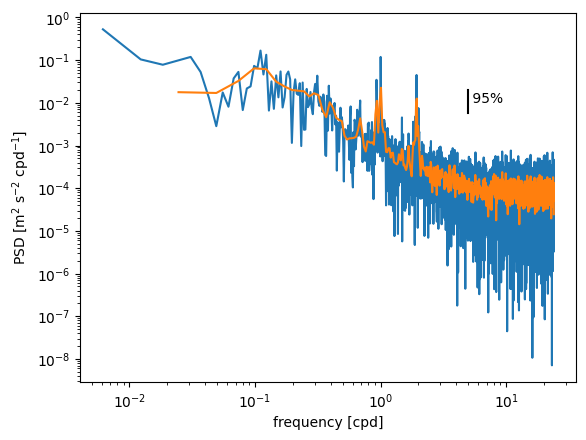

In [35]:
# raw periodogram (noisy, biased)
f,S = welch(ds['vda'],fs=48,nperseg=N,window='boxcar', detrend='constant')

plt.figure()
plt.loglog(f[1:],S[1:])
plt.xlabel('frequency [cpd]') # units? cycles per day
plt.ylabel('PSD [m$^2$ s$^{-2}$ cpd$^{-1}$]') # units? variance per unit frequency

# Welch's method with overlapping segments and Hann window
winlen = N/4
f2,S2 = welch(ds['vda'],fs=48.,nperseg=winlen,window='hann',detrend='linear')

plt.loglog(f2[1:],S2[1:])

# confidence intervals
from scipy.stats import chi2

dof = N/winlen*2 # dof depends on window length, relative to length of time series
edof = (8/3)*dof # scale factor for using a sensible window (Hann) - see Emery and Thomson

lower = edof/chi2.ppf(0.975,edof)
upper = edof/chi2.ppf(0.025,edof)

fplot = 5 # horizontal position of CI on plot
Splot = 0.01 # vertical position of CI on plot

plt.plot([fplot,fplot],Splot*np.array([lower,upper]),'k-')
plt.text(fplot,Splot,' 95%')